In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from time import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Read and Vectorise Documents

Simple Wiki's abstracts

In [4]:
all_docs = !xmllint --shell ../data/simplewiki-latest-abstract.xml.gz <<< "cat //doc/abstract"

In [5]:
all_docs[:10]

['/ >  -------',
 '<abstract>April is the 4th month of the year, and comes between March and May. It is one of four months to have 30 days.</abstract>',
 ' -------',
 '<abstract>August (Aug.) is the 8th month of the year in the Gregorian calendar, coming between July and September.</abstract>',
 ' -------',
 '<abstract>Art is a creative activity by people.  These people are called artists.</abstract>',
 ' -------',
 '<abstract>A is the first letter of the English alphabet. The small letter, a, is used as a lower case vowel.</abstract>',
 ' -------',
 '<abstract>thumb|240px|This is what the air is made of</abstract>']

In [6]:
all_docs = all_docs[1::2]
len(all_docs)

130870

In [7]:
docs = [s for s in all_docs
        if 'United States' in s]
len(docs)

6130

* TF-IDF Vectoriser

In [10]:
n_features = 20000

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=1,
                                   max_features=n_features,
                                   lowercase=False,
                                   stop_words='english')
tfidf_vectorizer.fit(all_docs)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
tfidf = tfidf_vectorizer.transform(docs)
tfidf.shape

(6130, 20000)

* TF Vectoriser

In [13]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
                                max_features=n_features,
                                lowercase=False,
                                stop_words='english',
                                vocabulary=tfidf_vectorizer.vocabulary_)
tf_vectorizer.fit(all_docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.95, max_features=20000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary={'April': 1545, '4th': 919, 'month': 16237, 'year': 19948, 'comes': 12685, 'March': 6900, 'May': 7036, 'It': 5717, 'months': 16239, '30': 746, 'days': 13200, 'August': 1715, '8th': 1086, 'Gregorian': 4915, 'calendar': 12207, 'coming': 12691, 'July': 5939, 'September': 9358, 'Art': 1629, '...usa': 1860, 'Arthrostylidium': 1631, 'Losser': 6607, 'Zorlu': 11154, 'Takam': 10011, 'Parvat': 8179})

In [14]:
tf = tf_vectorizer.transform(docs)
tf.shape

(6130, 20000)

Histogram of nnz of the entire corpus:

Text(0.5,1,'Histogram of NNZ of All Documents')

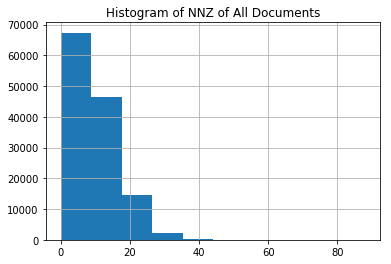

In [18]:
plt.hist(tf_vectorizer.transform(all_docs).sum(axis=1))
plt.grid()
plt.title('Histogram of NNZ of All Documents')

# Topic Modelling

In [19]:
def print_top_words_factors(factors, feature_names, n_top_words):
    ''' Print top words of each topic '''
    for topic_idx, topic in enumerate(factors):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def print_top_words(model, feature_names, n_top_words):
    ''' Print top words of each topic '''
    print_top_words_factors(model.components_, feature_names, n_top_words)

## NMF

In [20]:
nmf = NMF(n_components=10, init='random', alpha=.3, l1_ratio=1e-6)
nmf.fit(tfidf)
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: Kentucky city States United Kenton Hills County Park Indiana Hardin Harlan Estates Village Oklahoma Manor Creek Mount Hill City Heights
Topic #1: Iowa city States United City Oklahoma Rock Grove Indiana Lake 2000 St Center Junction people Mount Rapids population Sioux Mitchell
Topic #2: States United birth_place California The Texas Massachusetts It Angeles Los Ohio President country Louisiana Pennsylvania American Oklahoma Canada Missouri Washington
Topic #3: New York City States United birth_place Brooklyn Jersey Dutchess Manhattan community Bronx Queens County skyscraper meters tall floors feet death_place
Topic #4: Illinois city States United Chicago birth_place Park Heights Mount Peoria City Oak Cook Evanston Zion Galena Will Belleville Sterling Bridgeport
Topic #5: Idaho city States United Oklahoma Indiana Falls City Springs St Ferry Lake Ohio Hope Twin Teton Franklin Spencer Winchester Bellevue
Topic #6: Florida city States United Beach Oklahoma Miami Indiana seat Lake

## Latent Dirichlet Allocation

Variational Inference for LDA

In [22]:
lda = LatentDirichletAllocation(n_components=10,
                                doc_topic_prior=1,
                                topic_word_prior=1,
                                max_iter=10,
                                learning_method='online')
lda.fit(tf)
print_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words=20)

Topic #0: States United city County Iowa state Kentucky birth_place Illinois It Virginia town population 2010 census county Florida people America seat
Topic #1: birth_place Houston Boston cultural_origins origin chicken Atlanta Social Origin places Ontario Montana Portland death_place residence Index Death country alloy locations
Topic #2: birth_place Houston Boston cultural_origins origin chicken Atlanta Social Origin places Ontario Montana Portland death_place residence Death Index country alloy locations
Topic #3: birth_place Houston Boston cultural_origins origin chicken Atlanta Social Origin places Ontario Montana Portland death_place residence Index Death country alloy locations
Topic #4: birth_place Houston Boston cultural_origins origin chicken Atlanta Social Origin places Ontario Montana Portland death_place residence Death Index country alloy locations
Topic #5: birth_place Houston Boston cultural_origins origin chicken Atlanta Social Origin places Ontario Montana Portland d

## Spectral LDA

In [23]:
import sys
sys.path.insert(0, '../SpectralLDA')

from spectral_lda import spectral_lda

Using numpy backend.
Using numpy backend.


In [24]:
alpha, beta = spectral_lda(tf, alpha0=10, k=10)
print_top_words_factors(beta.T, tf_vectorizer.get_feature_names(), 20)

# docs: 6130	# valid: 6106


Topic #0: States United city Iowa York City Kentucky Idaho Brooklyn Mount Jersey Park Hills Chicago St Grove Lake Illinois Rock Heights
Topic #1: States York The American City It He people born President War January February March Brooklyn known University September April July
Topic #2: United The York American It City He people born President War January February March known University September April July Brooklyn
Topic #3: city birth_place The Iowa It Virginia state County Kentucky America town country Idaho American President Canada people government Army thumb
Topic #4: city The It California America Arkansas Texas Virginia Massachusetts country American President county census Pennsylvania Canada Louisiana Alabama Ohio government
Topic #5: city States United state Arkansas America Indiana City Springs Rock Sebastian Clarksville Jonesboro Monticello Camden London Delaware living Decatur West
Topic #6: States United York New City birth_place Jersey Brooklyn California Chicago Texas

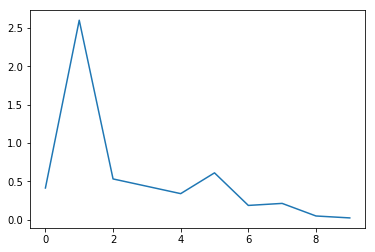

In [25]:
plt.plot(alpha)

In [26]:
alpha.sum()

5.396717959560388